### Question 2

Using data up to the 2022-W26, build one or more models to predict the average daily polyclinic
attendance for acute conjunctivitis, acute diarrhoea, and acute upper respiratory tract infections for
the remaining epidemiological weeks in 2022.
Compare your results against the actual attendance numbers for these weeks and discuss what you
did to adjust your model(s) for each disease.

In [43]:
import pandas as pd 
import matplotlib.pyplot as plt

In [57]:
poly_df = pd.read_csv("../data/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv") 

#filter for the relevant diseases
diseases = ['Acute Upper Respiratory Tract infections', 'Acute Conjunctivitis','Acute Diarrhoea'] 
poly_df = poly_df[poly_df['disease'].isin(diseases)].reset_index(drop=True)

In [58]:
poly_df[['epi_year', 'epi_week']] = poly_df['epi_week'].str.split('-W', expand=True)
#use the date of the monday of that week to mark the "start" of the week 
poly_df["epi_date"] = pd.to_datetime(poly_df["epi_year"].astype(str) + poly_df["epi_week"].astype(str) + "-1", format="%G%V-%u")
poly_df['epi_year'] = poly_df['epi_year'].astype('int')
poly_df['epi_week'] = poly_df['epi_week'].astype('int')

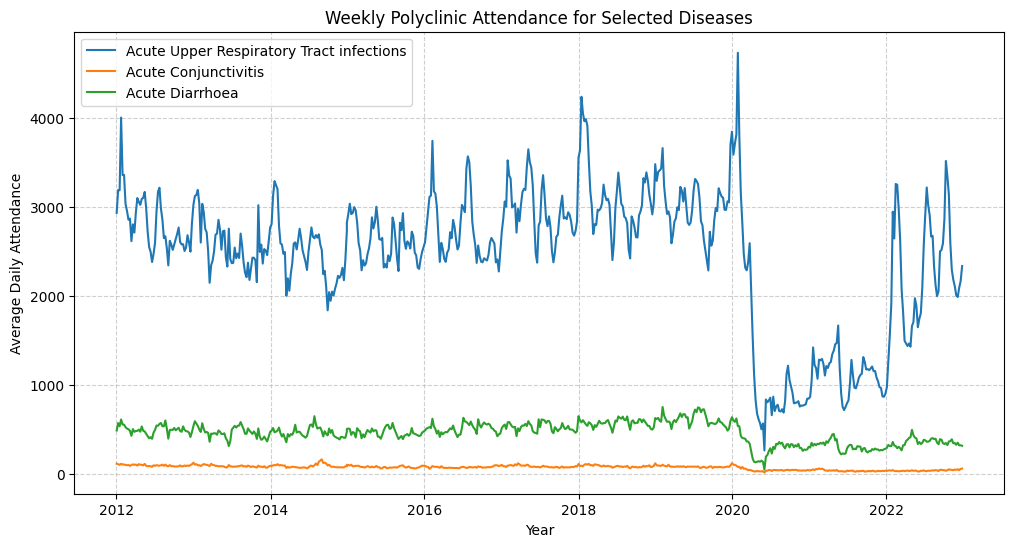

In [59]:
#visualising all the data to get a general sense 

# Plot trends
plt.figure(figsize=(12, 6))
for disease in diseases:
    subset = poly_df[poly_df["disease"] == disease]
    plt.plot(subset["epi_date"], subset["no._of_cases"], label=disease)

plt.title("Weekly Polyclinic Attendance for Selected Diseases")
plt.xlabel("Year")
plt.ylabel("Average Daily Attendance")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [94]:
poly_df

,epi_week,disease,no._of_cases,epi_year,epi_date
0,1,Acute Upper Respiratory Tract infections,2932,2012,2012-01-02
1,1,Acute Conjunctivitis,120,2012,2012-01-02
2,1,Acute Diarrhoea,491,2012,2012-01-02
3,2,Acute Upper Respiratory Tract infections,3189,2012,2012-01-09
4,2,Acute Conjunctivitis,114,2012,2012-01-09
...,...,...,...,...,...
1717,51,Acute Conjunctivitis,61,2022,2022-12-19
1718,51,Acute Diarrhoea,326,2022,2022-12-19
1719,52,Acute Upper Respiratory Tract infections,2336,2022,2022-12-26
1720,52,Acute Conjunctivitis,64,2022,2022-12-26


In [ ]:
#in 2020 due to covid, number of attendees dropped to its lowest since people would avoid going to clinics 
poly_df.loc[poly_df.groupby(['disease'])['no._of_cases'].idxmin()]

,epi_week,disease,no._of_cases,epi_year,epi_date
1318,23,Acute Conjunctivitis,18,2020,2020-06-01
1319,23,Acute Diarrhoea,55,2020,2020-06-01
1317,23,Acute Upper Respiratory Tract infections,268,2020,2020-06-01


In [ ]:
#dataset for after mid 2020 

# poly_post_covid = poly_df[(poly_df["epi_year"] > 2020) | ((poly_df["epi_year"] == 2020) & (poly_df["epi_week"] > 26))]


## Train Baseline XGBoost model for each disease

In [78]:
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import sklearn
import numpy as np

In [115]:
#define function to train an xgboost model to predict the disease 

def prepare_data(input_df, disease_type): 
    df = input_df[input_df['disease'] == disease_type].reset_index(drop = True)
    df['lag_1'] = df['no._of_cases'].shift(1)
    df['lag_2'] = df['no._of_cases'].shift(2)
    df['rolling_mean_4'] = df['no._of_cases'].rolling(window=4).mean()  # 4-week rolling mean
    df.dropna(inplace=True) 

    #prepare test and train data frames
    df_test = df[(df['epi_year'] == 2022) & (df['epi_week'] > 26)]
    df_train = df.drop(df_test.index, axis=0)

    #prepare test and train data 
    X_train = df_train[['lag_1', 'lag_2', 'rolling_mean_4', 'epi_week', 'epi_year']]
    y_train = df_train['no._of_cases']
    X_test = df_test[['lag_1', 'lag_2', 'rolling_mean_4', 'epi_week', 'epi_year']]
    y_test = df_test['no._of_cases']

    return X_train, y_train, X_test, y_test 



In [116]:
#data for ac infection 

X_train_aurt, y_train_aurt, X_test_aurt, y_test_aurt = prepare_data(poly_df , "Acute Upper Respiratory Tract infections")

In [117]:
#data for conjunctivities 
X_train_ac, y_train_ac, X_test_ac, y_test_ac = prepare_data(poly_df , 'Acute Conjunctivitis' )

In [118]:
#data for diarrhea
X_train_ad, y_train_ad, X_test_ad, y_test_ad = prepare_data(poly_df, 'Acute Diarrhoea' )

In [119]:
#model for AURT
aurt_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
aurt_model.fit(X_train_aurt, y_train_aurt)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [120]:
#model for AC
ac_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
ac_model.fit(X_train_ac, y_train_ac)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [121]:
#model for AD
ad_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
ad_model.fit(X_train_ad, y_train_ad)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [122]:
y_pred_aurt = aurt_model.predict(X_test_aurt)
y_pred_ac = ac_model.predict(X_test_ac)
y_pred_ad = ad_model.predict(X_test_ad)

In [123]:
def display_metrics(y_test, y_pred):

    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mape = (abs(y_test - y_pred) / y_test).mean() * 100

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    return


In [124]:

display_metrics(y_test_aurt,y_pred_aurt)

Mean Absolute Error (MAE): 204.62
Root Mean Squared Error (RMSE): 261.58
Mean Absolute Percentage Error (MAPE): 7.92%


In [125]:
display_metrics(y_test_ac,y_pred_ac)

Mean Absolute Error (MAE): 3.41
Root Mean Squared Error (RMSE): 4.22
Mean Absolute Percentage Error (MAPE): 7.07%


In [126]:
display_metrics(y_test_ad,y_pred_ad)

Mean Absolute Error (MAE): 14.71
Root Mean Squared Error (RMSE): 17.76
Mean Absolute Percentage Error (MAPE): 4.06%


In [88]:
def plot_comparison(y_test, y_pred, disease):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test, label='Actual', color='orange')
    plt.plot(y_test.index, y_pred, label='Predicted', color='blue', linestyle='--')
    plt.title(f'Actual vs Predicted Attendance ({disease})')
    plt.xlabel('Date')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.grid()
    plt.show()

    return 

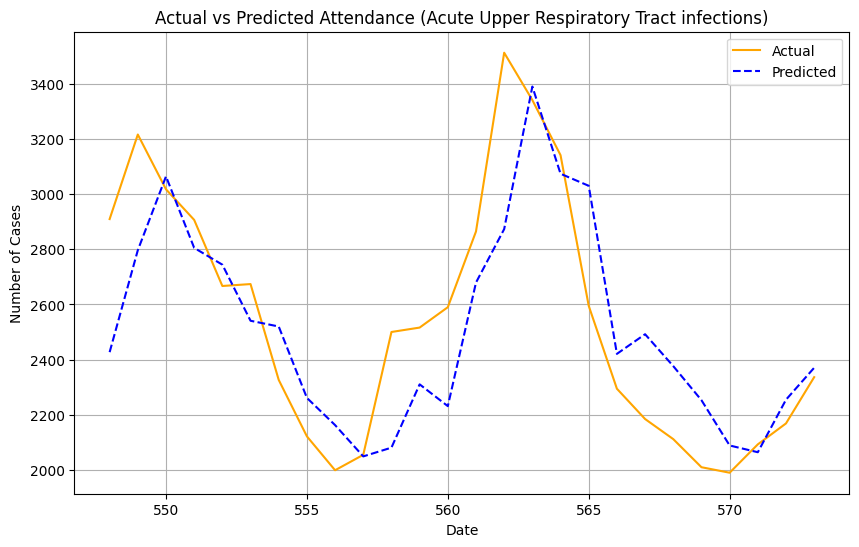

In [89]:
plot_comparison(y_test_aurt, y_pred_aurt, 'Acute Upper Respiratory Tract infections')

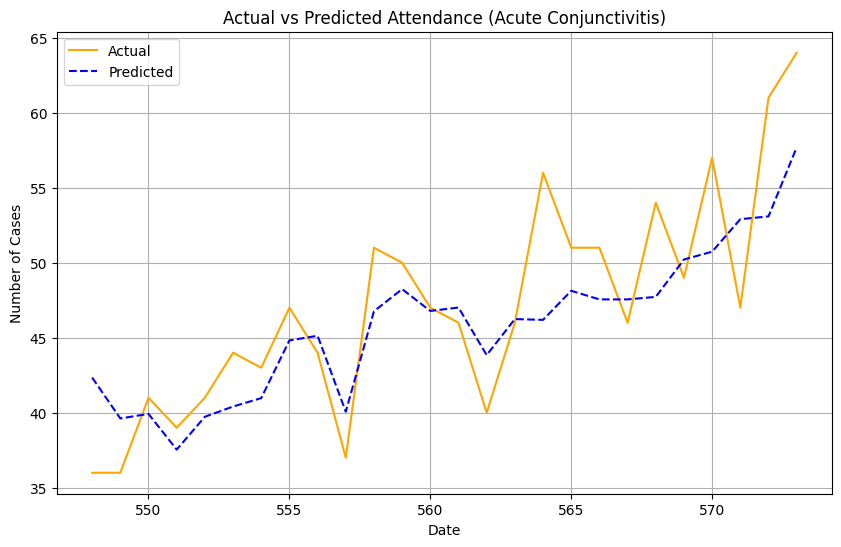

In [90]:
plot_comparison(y_test_ac, y_pred_ac, 'Acute Conjunctivitis')

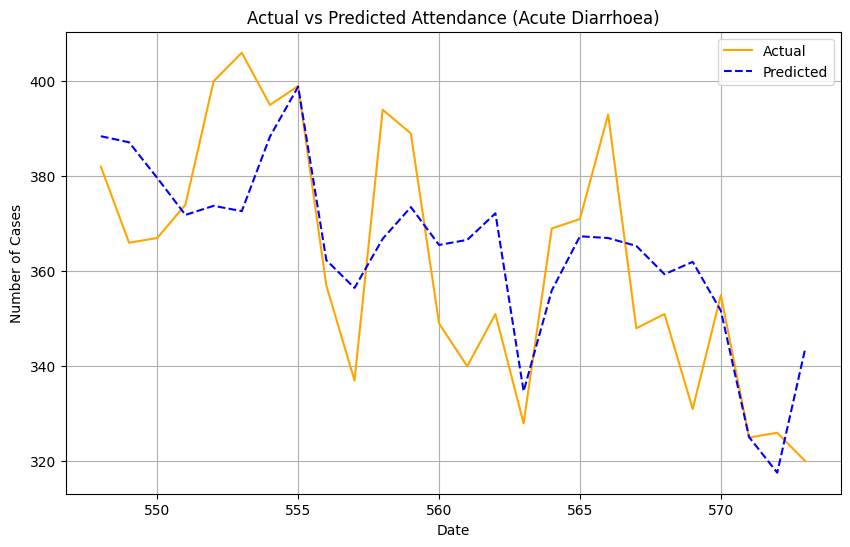

In [91]:
plot_comparison(y_test_ad, y_pred_ad, 'Acute Diarrhoea')

## Improving the Models through Grid Search 

Run a grid search for optimal parameters for each model to see if it benefits the predictions

In [152]:

from sklearn.model_selection import GridSearchCV

param_grid = {

    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0]
}


In [153]:
#grid search for AURT
aurt_gs = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror',  n_estimators=150), param_grid, cv = 3, verbose=2)
aurt_gs.fit(X_train_aurt, y_train_aurt)
best_params_aurt = aurt_gs.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   8.5s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.3s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.1s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=  12.4s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.1s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=  23.1s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=  18.0s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.1s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.1s
[CV] END .....learning_rate=0.01, max_depth=5, 

In [157]:
best_params_aurt

{'learning_rate': 0.2, 'max_depth': 5, 'subsample': 1.0}

In [154]:
aurt_final = xgb.XGBRegressor(objective='reg:squarederror', **best_params_aurt)
aurt_final.fit(X_train_aurt, y_train_aurt)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [156]:
y_final_aurt = aurt_final.predict(X_test_aurt)
display_metrics(y_test_aurt,y_final_aurt)

Mean Absolute Error (MAE): 208.54
Root Mean Squared Error (RMSE): 251.10
Mean Absolute Percentage Error (MAPE): 8.32%


In [ ]:
#grid search for AAC
ac_gs = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv = 3, verbose=2)
ac_gs.fit(X_train_ac, y_train_ac)
best_params_ac = ac_gs.best_params_
best_params_ac 

Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   3.5s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, s

{'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}

In [147]:
ac_final = xgb.XGBRegressor(objective='reg:squarederror', **best_params_ac)
ac_final.fit(X_train_ac, y_train_ac)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [148]:
y_final_ac = ac_final.predict(X_test_ac)
display_metrics(y_test_ac,y_final_ac)

Mean Absolute Error (MAE): 3.08
Root Mean Squared Error (RMSE): 4.02
Mean Absolute Percentage Error (MAPE): 6.35%


In [ ]:
#grid search for AAC
ad_gs = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror'), param_grid, cv = 3, verbose=2)
ad_gs.fit(X_train_ad, y_train_ad)
best_params_ad = ad_gs.best_params_
best_params_ad 


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.2s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=0.9; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=3, subsample=1.0; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, subsample=0.8; total time=   0.0s
[CV] END .....learning_rate=0.01, max_depth=5, s

{'learning_rate': 0.2, 'max_depth': 3, 'subsample': 0.8}

In [150]:
ad_final = xgb.XGBRegressor(objective='reg:squarederror', **best_params_ad)
ad_final.fit(X_train_ad, y_train_ad)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [151]:
y_final_ad = ad_final.predict(X_test_ad)
display_metrics(y_test_ad,y_final_ad)

Mean Absolute Error (MAE): 16.10
Root Mean Squared Error (RMSE): 19.35
Mean Absolute Percentage Error (MAPE): 4.43%
